# Read coords from existing DEG

In [7]:
import deg

# read graph from drive
graph_file = "G:/My Drive/HTW/PhD/2DGraph/automatic/L2_K4_AddK10Eps0.2High_SwapK10-0StepEps0.001LowPath5Rnd100+0_improveNonRNGAndSecondHalfOfNonPerfectEdges_RNGAddMinimalSwapAtStep0.add_rng_opt.deg"

graph_file = "G:/My Drive/HTW/PhD/2DGraph/V30_L2_K4_AddK8Eps0.2High_SwapK8-0StepEps0.001Low.deg"

# use features as coords
coords = deg.read_deg_vertices(graph_file)
print(coords.shape)
coords.head()

(30, 4)


,id,feature,color,geometry
0,0,"[73.01615, 25.27309]",black,POINT (73.016 25.273)
1,1,"[76.6436, 81.619644]",black,POINT (76.644 81.62)
2,2,"[59.095734, 99.37522]",black,POINT (59.096 99.375)
3,3,"[92.944084, 14.437962]",black,POINT (92.944 14.438)
4,4,"[38.930744, 35.24164]",black,POINT (38.931 35.242)


s = coords.loc[5]  # Assuming s is the Series
index_label = s.index  # This returns the index label (e.g., 5 if it's an integer index)# Create random coords

In [8]:
from utils import create_random_coords

# example
coords = create_random_coords(n=40, scale=50, seed=42)
print(coords.shape)
coords.head()

(40, 4)


,id,feature,color,geometry
0,0,"[18.727005, 47.535717]",black,POINT (18.72701 47.53572)
1,1,"[36.599697, 29.932924]",black,POINT (36.5997 29.93292)
2,2,"[7.800932, 7.799726]",black,POINT (7.80093 7.79973)
3,3,"[2.9041805, 43.308807]",black,POINT (2.90418 43.30881)
4,4,"[30.05575, 35.40363]",black,POINT (30.05575 35.40363)


# Create all graphs

In [9]:
from graphs import GraphKind, build_graphs, extract_features

# gdf: your GeoDataFrame with a 'features' column and point 'geometry'
# Build all graph kinds (base + DEG) with a chosen edges_per_vertex
all_kinds = list(GraphKind)
graphs = build_graphs(coords, kinds=all_kinds, edges_per_vertex=4)

# Optional: inspect results
for g in graphs:
    edges = g.edges
    print(f"{g.title}: edges={getattr(edges, 'shape', getattr(edges, '__len__', lambda: 'n/a')())[0]}")

kNN Graph: edges=95
MST: edges=39
MRNG: edges=63
RNG: edges=43
GG: edges=62
DG: edges=104
DEG1: edges=80
DEG2: edges=80
DEG3: edges=80
DEG4: edges=80
DEG5: edges=51


## Plot the Graphs

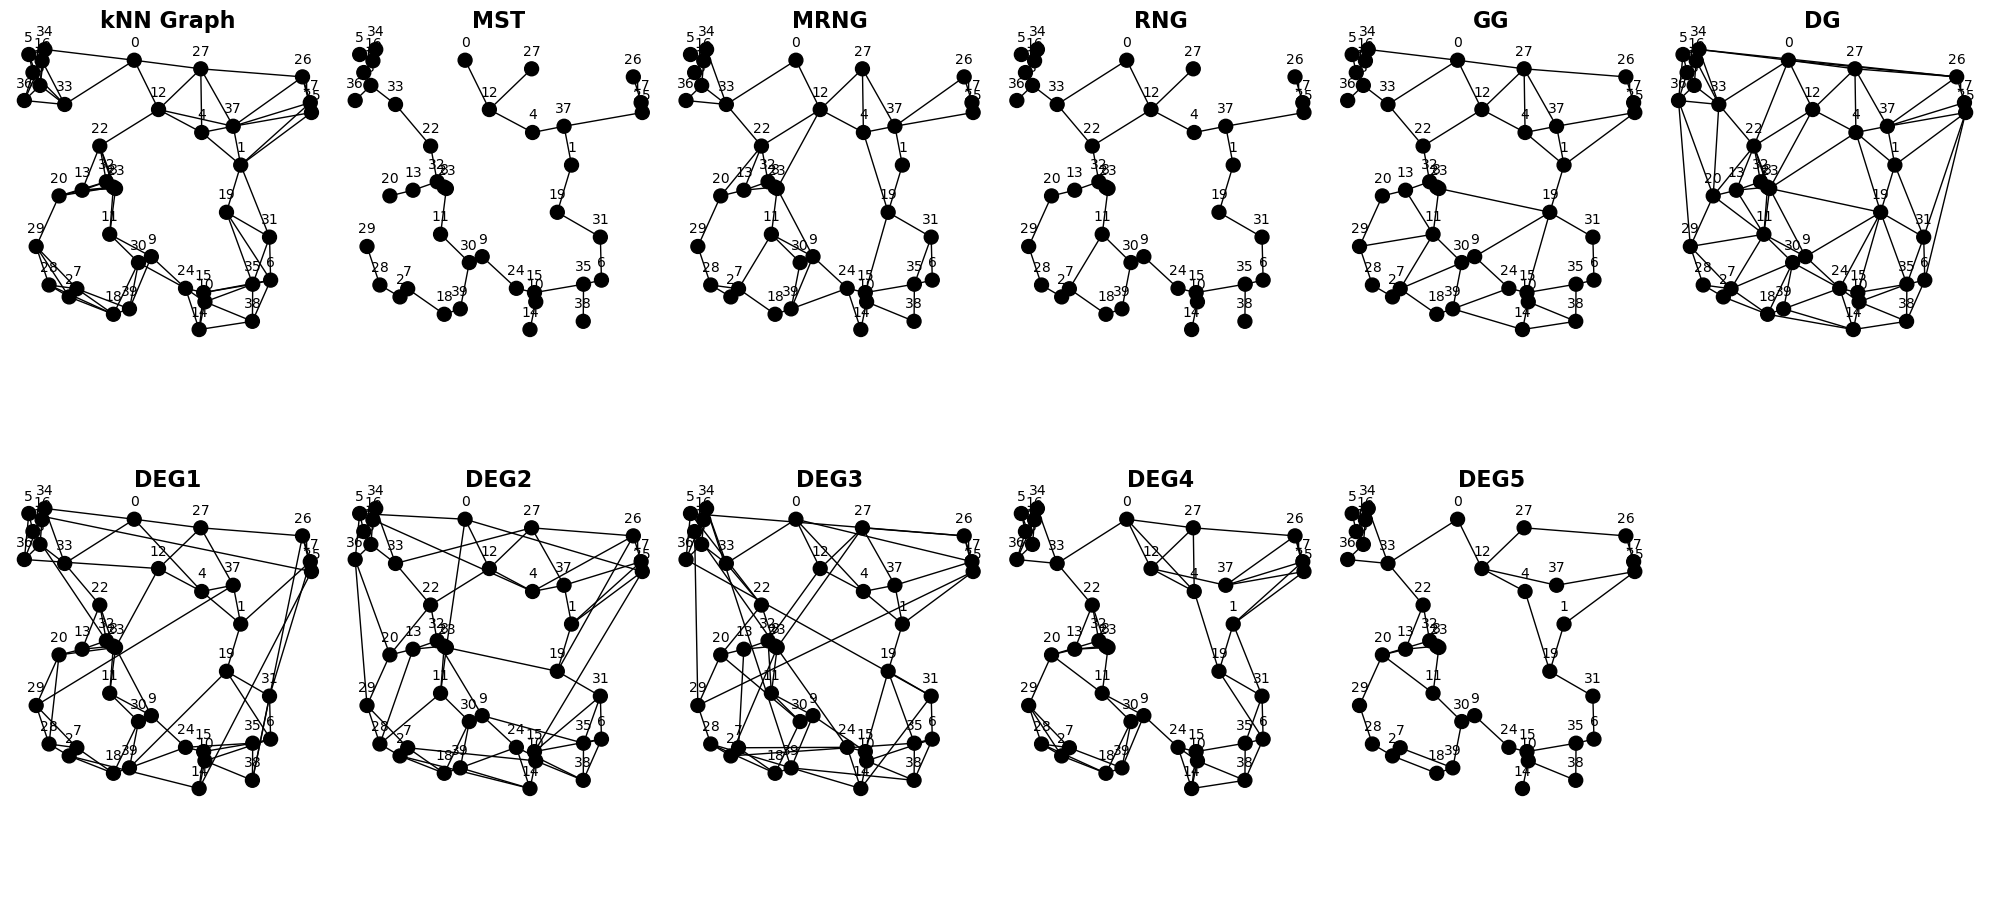

In [10]:
from plot import plot_graphs

# Example usage
plot_graphs(vertices=coords, graphs=graphs, bg_color="white", text_color="black", marker_size=100, edge_color="black", edge_width=1, save_file=None)

# Edge Overlap

In [11]:
from evaluate import print_edge_overlap
from typing import Dict

by_kind: Dict[GraphKind, any] = {it.kind: it for it in graphs}
mrng_edges = by_kind[GraphKind.MRNG].edges

print_edge_overlap("KNN", mrng_edges, by_kind[GraphKind.KNN].edges)
print_edge_overlap("MST", mrng_edges, by_kind[GraphKind.MST].edges)
print_edge_overlap("RNG", mrng_edges, by_kind[GraphKind.RNG].edges)
print_edge_overlap("DG",  mrng_edges, by_kind[GraphKind.DG].edges)
print_edge_overlap("GG",  mrng_edges, by_kind[GraphKind.GG].edges)
print_edge_overlap("DEG1", mrng_edges, by_kind[GraphKind.DEG1].edges)
print_edge_overlap("DEG2", mrng_edges, by_kind[GraphKind.DEG2].edges)
print_edge_overlap("DEG3", mrng_edges, by_kind[GraphKind.DEG3].edges)
print_edge_overlap("DEG4", mrng_edges, by_kind[GraphKind.DEG4].edges)
print_edge_overlap("DEG5", mrng_edges, by_kind[GraphKind.DEG5].edges)

KNN       54/ 63 ( 85.71%)    54/ 95 ( 56.84%)  avg=  7.458
MST       39/ 63 ( 61.90%)    39/ 39 (100.00%)  avg=  5.362
RNG       43/ 63 ( 68.25%)    43/ 43 (100.00%)  avg=  5.920
DG        62/ 63 ( 98.41%)    62/104 ( 59.62%)  avg=  9.527
GG        48/ 63 ( 76.19%)    48/ 62 ( 77.42%)  avg=  7.568
DEG1      49/ 63 ( 77.78%)    49/ 80 ( 61.25%)  avg= 10.322
DEG2      30/ 63 ( 47.62%)    30/ 80 ( 37.50%)  avg= 10.280
DEG3      25/ 63 ( 39.68%)    25/ 80 ( 31.25%)  avg= 12.177
DEG4      23/ 63 ( 36.51%)    23/ 80 ( 28.75%)  avg=  7.529
DEG5      20/ 63 ( 31.75%)    20/ 51 ( 39.22%)  avg=  6.785


# Search Performance

In [12]:
from evaluate import exact_knn, calc_recall

features = extract_features(coords)
indices_exact, dist_exact = exact_knn(features, k=4)

# search query
graphs = {
    "DEG1": by_kind[GraphKind.DEG1].graph,
    "DEG2": by_kind[GraphKind.DEG2].graph,
    "DEG3": by_kind[GraphKind.DEG3].graph,
    "DEG4": by_kind[GraphKind.DEG4].graph,
    "DEG5": by_kind[GraphKind.DEG5].graph
}

for name, g in graphs.items():
    indices_approx, distances_approx = g.search(features, eps=0.0, k=5)
    recall = calc_recall(indices_approx[:,1:], indices_exact)
    print(f"{name}: Recall = {recall:.3f}")

DEG1: Recall = 0.988
DEG2: Recall = 1.000
DEG3: Recall = 0.994
DEG4: Recall = 0.994
DEG5: Recall = 0.994
